In [3]:
# get events
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy.core.event.catalog import Catalog
import numpy as np
from obspy import read_events


minmag = 0
try:
    evts = read_events(f'MSH_events_map_minmag{minmag}.xml')
except FileNotFoundError:
    c = Client('USGS', timeout=240)

    lat = [45.95, 46.45]
    lon = [-122.45, -121.96]


    starttime = UTCDateTime(year=1998, julday=1)
    endtime = UTCDateTime(year=2023, julday=300)
    delta = 86400*365
    rtimes = np.linspace(starttime.timestamp, endtime.timestamp, 12)
    # rtimes = np.arange(starttime.timestamp, endtime.timestamp, delta)
    evts = Catalog()



    for ii, rtime in enumerate(rtimes):
        if ii == len(rtimes)-1:
            break
        start = UTCDateTime(rtime)
        end = UTCDateTime(rtimes[ii+1])
        print(f'downloading events from {start} to {end}')
        evts.extend(c.get_events(
            starttime=start, endtime=end, minmagnitude=minmag, maxdepth=15,
            minlatitude=lat[0], maxlatitude=lat[1], minlongitude=lon[0],
            maxlongitude=lon[1]))
    evts.write(f'MSH_events_map_minmag{minmag}.xml', format='QUAKEML')

otimes = [evt.preferred_origin().time.datetime for evt in evts]
hypz = [-evt.preferred_origin().depth for evt in evts]
hyplats = [evt.preferred_origin().latitude for evt in evts]
hyplons = [evt.preferred_origin().longitude for evt in evts]

pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)
plot [WARNING]: Cannot use auto-legend -l for variable symbol color. Option -l ignored.


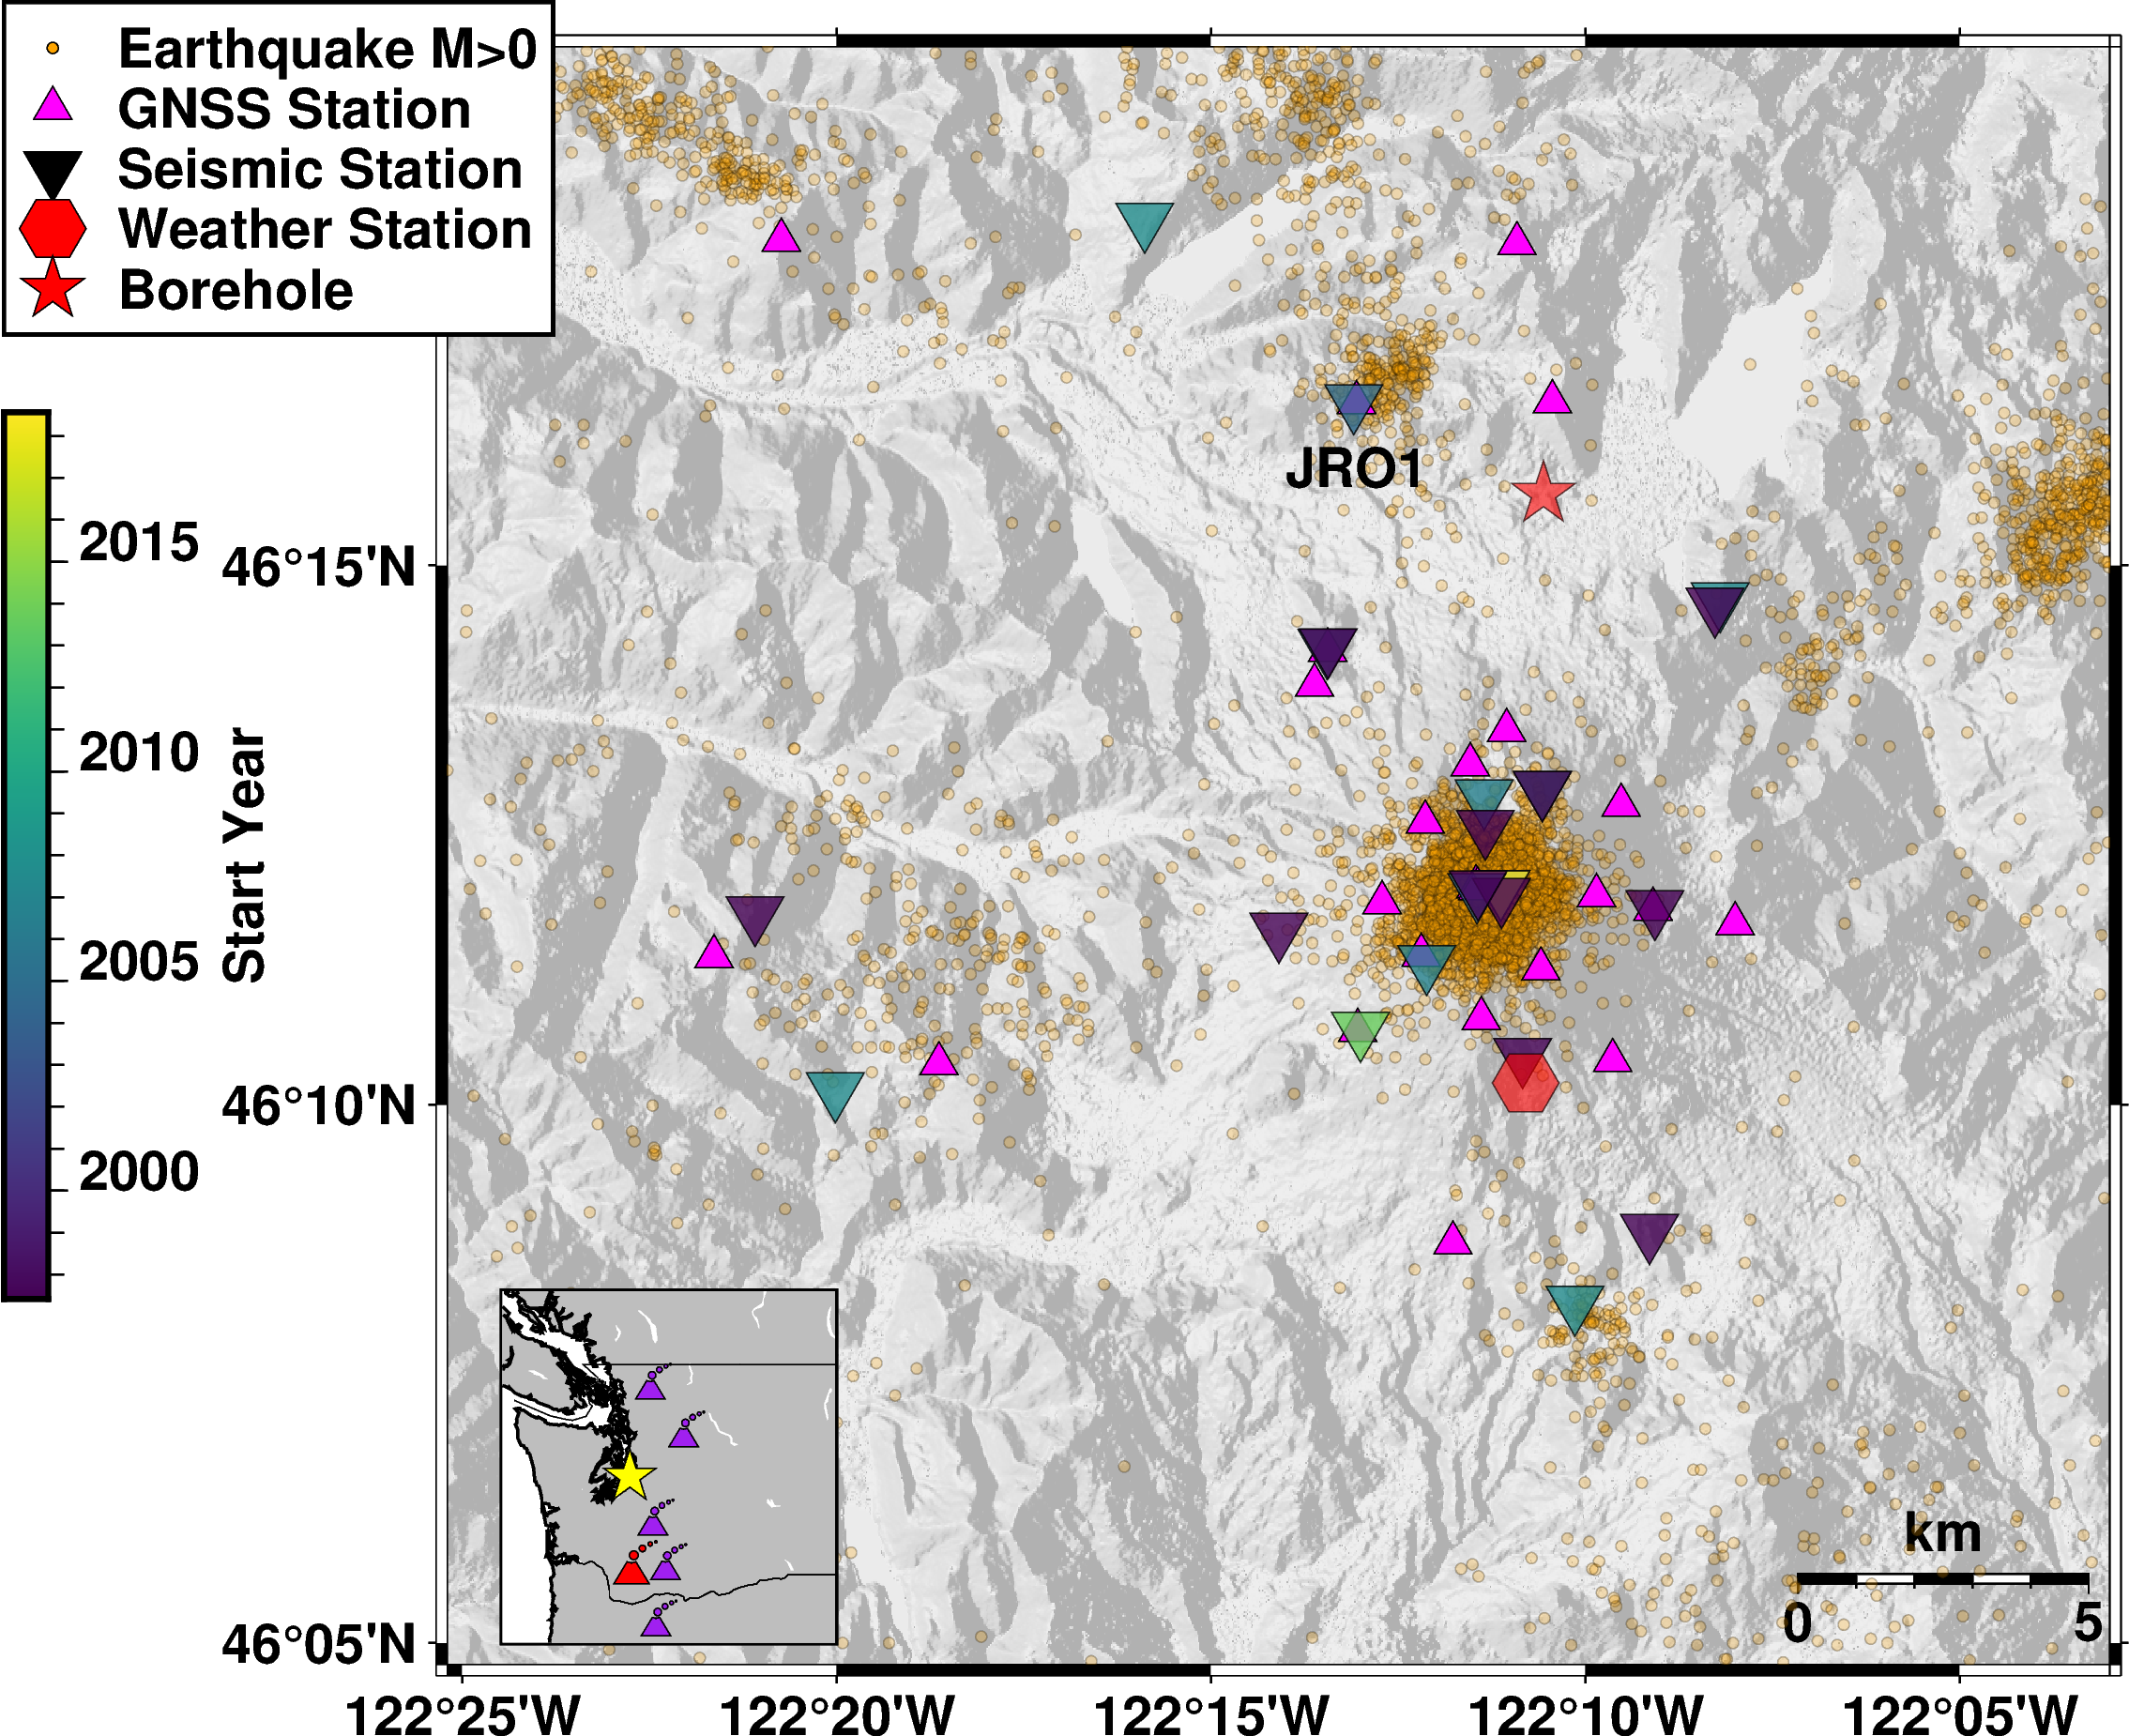

In [11]:
import numpy as np
import pygmt
import pandas as pd

import datetime


# GPS stations
coord_file = '/home/pm/Documents_sync/PhD/StHelens/gnss_cleaned/coords.txt'
df_coords = pd.read_csv(
    coord_file, delim_whitespace=True, skipinitialspace=True, names=('station', 'lat', 'lon', 'elevation'))

# seismic stations
stats = pd.read_csv('stat_locs.txt', sep='|', header=0)
stats['StartTime'] = pd.to_datetime(stats['StartTime'])
# replace starttime by June 1, 1997 if it is before that
stats.loc[stats.StartTime < datetime.datetime(1997, 6, 1), 'StartTime'] = datetime.datetime(1997, 6, 1)
# 2 is lat 3 is lon
region = [
    -122.42,
    -122.05,
    46.08,
    46.33,
]

helen = (46.191, -122.196)


pygmt.config(FONT='14p,Helvetica-Bold')#, FORMAT_GEO_MAP="ddd.xx")

fig = pygmt.Figure()
# relief
grid = pygmt.datasets.load_earth_relief(resolution='01s', region=region)
dgrid = pygmt.grdgradient(grid=grid, radiance=[270, 30])
fig.coast(lakes='blue', rivers='blue', resolution='f')
# make coordinates in decimal degrees



# make cmap black and white
fig.grdimage(
    transparency=65, grid=dgrid, projection="M15c", cmap=True, monochrome=True)

fig.basemap(
    region=region, projection="M15c", frame=["a"], #rose="n1.1/0.92+w1.6c+f3+l",
    map_scale="n0.9c/0.05c+w5k+f3+lkm")

    # map_scale="n-0.15c/0.1c+w5k+f3+lkm")

pygmt.makecpt(
    cmap="viridis", series=[min(stats.StartTime), max(stats.StartTime)])

fig.plot(x=hyplons, y=hyplats, style='c0.1c', color='orange', pen='black', label='Earthquake M>0', transparency=75)


# print(df_coords[jro1_i])
# plot GPS stations
fig.plot(
    x=df_coords.lon, y=df_coords.lat, style='t0.4c', cmap=False,
    color='magenta', pen='black', label='GNSS Station')
jro1_i = df_coords.station=='JRO1'
fig.text(
    text='JRO1', x=df_coords[jro1_i].lon, y=df_coords[jro1_i].lat-.01)
# fig.plot(
    
# )
fig.plot(
    x=stats.Longitude, y=stats.Latitude, style="i0.6c", cmap=True,
    color=stats.StartTime, pen="black", label='Seismic Station', transparency=20)
fig.plot(x=np.nan, y=np.nan, style='i0.6c', pen='black', label='Seismic Station', color='black')

# plot weather station
weather = (46.17, -122.18)
fig.plot(
    x=weather[1], y=weather[0], style='h0.6c', color='red',pen='black',
    label='Weather Station', transparency=40)
# plot borehole
borehole = (46.26100, -122.17603)
fig.plot(
    x=borehole[1], y=borehole[0], style='a0.6c', color='red',pen='black',
    label='Borehole', transparency=40)


# put legend in upper left corner
fig.legend(
    position="jml+o-4c/6.2c",
    box="+gwhite+p1p")
# plot vertical ground motion as squares

# put the colorbar for the vertical offset
# left of the plot, centered, and vertical
# put colorbar further left
# put the label closer to the colorbar
fig.colorbar(
    frame="x+lStart Year", #position="JML+o-1.5c/0c+w3c/0.3c+h")
    position="jml+o-4c/0c+w8c/0.4c")#position="JML+o3c/0c+w9c")
# fig.plot(
#     x=helen[1], y=helen[0], style="kvolcano/1c", color="red", pen="white",
#     label='Volcanoes')

volcanoes = [
    # Mount Hood
    (45.373, -121.695),
    # Mount Adams
    (46.202, -121.491),
    # Mount Rainier
    (46.852, -121.760),
    # Mount St. Helens
    # (46.191, -122.196), 
    # Mount Baker
    (48.776, -121.814),
    # Glacier Peak
    (48.111, -121.111),
    # Mount Shasta
    (41.409, -122.194),
    # Mount Lassen
    (40.488, -121.505),
    # Sisters
    (44.103, -121.769),
    # Newberry
    (43.721, -121.229),
    # Crater Lake
    (42.944, -122.109)]

lonmid = (region[0] + region[1])/2
latmid = (region[2] + region[3])/2 - 10
# with fig.inset(position="jBR+w6.5c/6.5c+o-2.9c/-.9c"):
with fig.inset(position="jBL+o0.5c/0.2c",
    box="+pblack",
    region=[-125, -118, 45, 50],
    projection="M3c"):
    # fig.coast(
    #     projection=f"G{lonmid}/{latmid}/60/6.5c", region="g", frame="g",
    #     land="gray", water='white')
    fig.coast(
        land="gray",
        borders=[1, 2],
        shorelines="1/thin",
        water="white",
        # Use dcw to selectively highlight an area
        # dcw="US.WA+gred",
    )
    fig.plot(
        x=helen[1], y=helen[0], style="kvolcano/0.4c", color="red",
        pen="black", projection="M3c")
    fig.plot(
        x=[x[1] for x in volcanoes], y=[x[0] for x in volcanoes],
        style="kvolcano/0.33c", color="purple", pen="black", projection="M3c")
    # add coordinates of the 2001 nisqually earthquake
    fig.plot(
        x=-122.325, y=47.425, style="kstar/0.5c", color="yellow",
        pen="black", projection="M3c")
fig.savefig('../paper/figures/station_map.png', dpi=300, transparent=True)
# fig.savefig('station_map.pdf' transparent=True)

fig.show()
